# Build a Binary Machine Learning Classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost

# MV's packages
import performance_metrics
import hyper_parameter_tuning
import model_prep

### Load, encode, split and scale data 

In [2]:
example_df = pd.read_csv('bank.csv', na_values=[np.nan])

# Drop features that are not meaningful for the analysis
drop_elements = ['ID', 'Unnamed: 0']
example_df = example_df.drop(drop_elements, axis=1)

# Basic NA cleaning

for col in example_df:
    dt = example_df[col].dtype
    if dt == int or dt == float:
        example_df[col].fillna(0)
    else:
        example_df[col].fillna('unknown')

# One-hot encoding of categorical features - note, data should only contain features and target

example_df = model_prep.one_hot_encode(df=example_df)

# Split data into train and test

Y = example_df['Y_2'].map(lambda x: 0 if x == 1 else 1 if x == 2 else -1)
x = example_df.drop('Y_2', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, stratify=Y, random_state=26)

# Scale data

scl = StandardScaler()
x_train_scaled = scl.fit_transform(x_train)
x_test_scaled = scl.transform(x_test)

## Hyper-parameter tuning

In [ ]:
sampling_methods = ['none', 'smote']
scores = ['roc_auc', 'f1_weighted']
model_names = ['RandomForestClassifier', 'xgboost', 'svm']

model_name = []
sampling_name = []
best_parameters = []
test_scores = []

for m in model_names:
    for s in sampling_methods:
        print(m)
        clf = hyper_parameter_tuning.course_hyper_parameter_cv(sampling_method=s, model_name=m,
                                                               scores=scores, k=5, x_train=x_train_scaled,
                                                               y_train=y_train, x_test=x_test_scaled,
                                                               y_test=y_test)
        best_p = clf.best_params_
        test_score = clf.score(x_test_scaled, y_test)
        model_name.append(m)
        sampling_name.append(s)
        best_parameters.append(best_p)
        test_scores.append(test_score)

hyper_parameter_tuning_results = pd.concat([pd.DataFrame(model_name, columns='model'),
                                           pd.DataFrame(sampling_name, columns='sampling'),
                                           pd.DataFrame(best_parameters),
                                           pd.DataFrame(test_scores, columns='test_score')],
                                           axis=1)

print('Collated results of hyper-parameter tuning:')
print(hyper_parameter_tuning_results)

## Assessing the Performance of a Classifier

There are many metrics available to assess the performance of your model. While the metrics you choose will be dependent on the problem and norms in your field, each has its own benefits and weaknesses so it is best not to rely on just one. Visual analysis can also be useful for understanding the performance of your model and trade-offs that can be made. In the next section we will produce the following metrics and plots using a local package.

**Performance Metrics:**
* Accuracy
* F1
* Recall
* Precision
* ROC_AUC
* Gini Co-efficient
* Log Loss

**Performance Plots:**
* Confusion Matrix
* Precision-Recall Curve
* ROC Curve
* FPR, TPR by Probability Threshold
* Lift
* Gain

In [3]:
# Train strongest model based on tuning

rf = RandomForestClassifier(n_estimators=500, max_depth=20, oob_score=True, criterion='entropy', n_jobs=-1)
rf.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


Key Metrics:
accuracy               0.849244
f1                     0.848872
f1_weighted            0.848872
gini_coefficient       0.830696
log_loss               5.207013
precision_pos_class    0.817713
recall_pos_class       0.898866
roc_auc                0.915348
roc_auc_weighted       0.915348
dtype: float64

Classification Report:
             precision    recall  f1-score   support

     reject       0.89      0.80      0.84      1058
     accept       0.82      0.90      0.86      1058

avg / total       0.85      0.85      0.85      2116



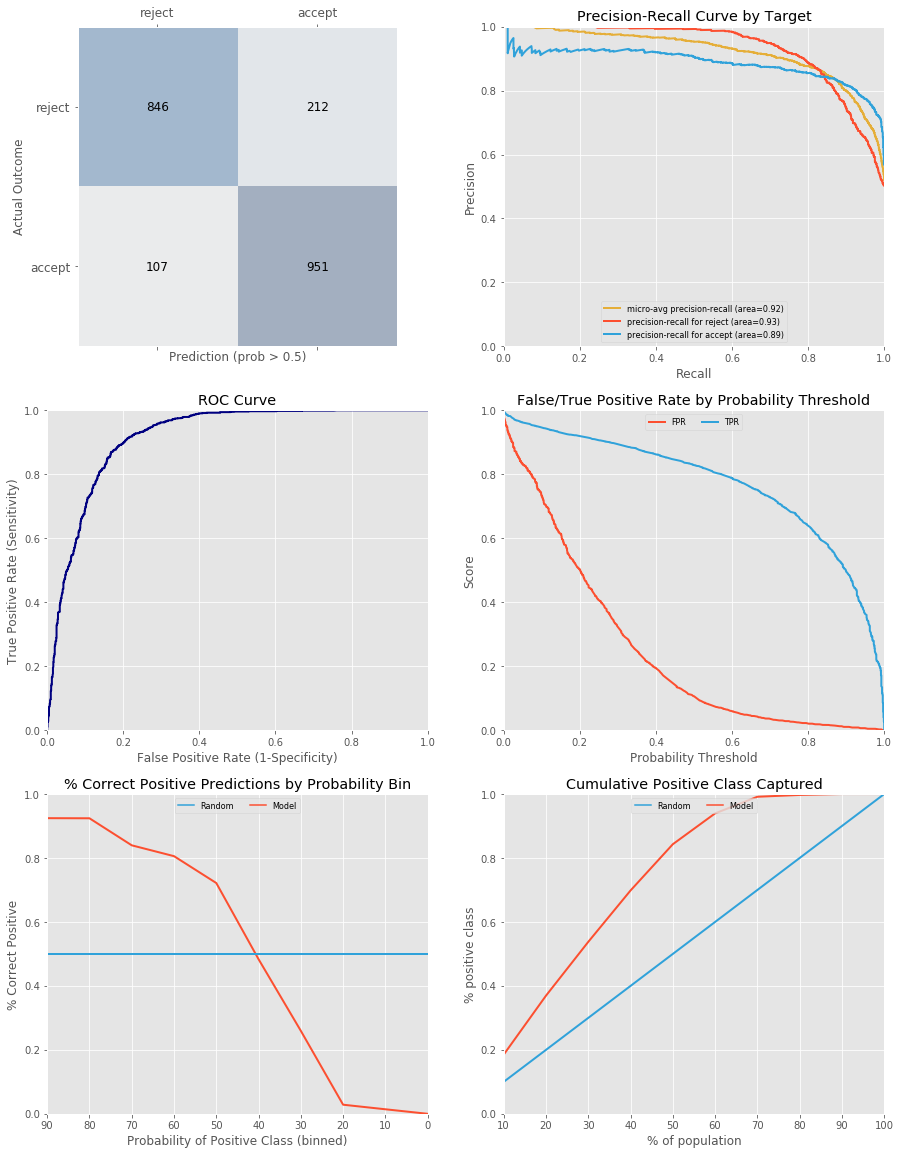

In [4]:
# Assess performance of classifier

target_names = ['reject', 'accept']

performance_df = performance_metrics.performance_metrics(clf=rf, x_test=x_test_scaled, y_test=y_test, target_names=target_names)
performance_plots = performance_metrics.performance_plots(clf=rf, x_test=x_test_scaled, y_test=y_test, target_names=target_names)